In [1]:
from nbdev.showdoc import *
import numpy as np
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device = torch.device("cpu") # seems to be a bug in pytorch where using mps causes nans to appear
print("Using device",device)
%load_ext autoreload
%autoreload 2

Using device cpu


# FREDaGAN Embeddings

This notebook interfaces with papermill to automate the laborious parts of model testing. Just specify the dataset and model name, and this notebook will test it.

In [2]:
# Papermill Parameters
dataset = "Double Helix"
model = "FREDaGAN Plain"
n_epochs = 500
n_nodes = 256
n_critic = 5
weight_clipping_value = 0.01

In [3]:
from FEARFRED.gan import FRED_A_GAN
if model == "FREDaGAN Plain":
    fred = FRED_A_GAN(
        intrinsic_dimension = 2,
        n_nodes = n_nodes,
        n_features = 1
    )
elif model == "FREDaGAN Laplacian Scattering":
    fred = FRED_A_GAN(
        intrinsic_dimension = 2,
        n_nodes = n_nodes,
        n_features = 1
    )
else:
    fred = FRED_A_GAN(
        intrinsic_dimension = 2,
        n_nodes = n_nodes,
        n_features = 1
    )
fred = fred.to(device)
opt_gen = torch.optim.Adam(fred.generator.parameters())
opt_discrim = torch.optim.Adam(fred.discriminator.parameters())

In [4]:
from FEARFRED.datasets.manifolds import DirectedCircle, SwissRoll, DoubleHelix
from torch.utils.data import DataLoader
if dataset == "Directed Circle":
    d = DirectedCircle(n_nodes=n_nodes)
elif dataset == "Swiss Roll":
    d = SwissRoll(n_nodes=n_nodes)
elif dataset == "Double Helix":
    d = DoubleHelix(n_nodes=n_nodes)
elif dataset == "Noisy Double Helix":
    d = DoubleHelix(
        n_nodes=n_nodes,
        noise=0.1
    )
dataloader = DataLoader(d, batch_size=1)

torch.Size([256, 256])


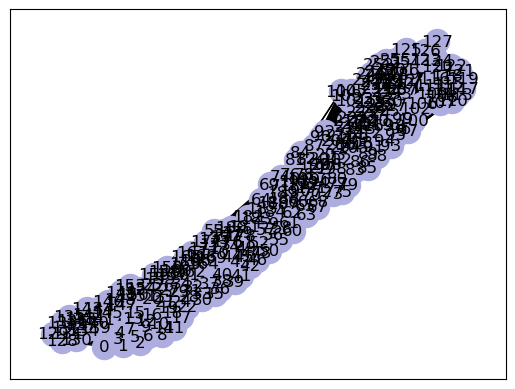

In [5]:
from FEARFRED.datasets.manifolds import SwissRoll
from torch.utils.data import DataLoader
from FEARFRED.plotting import visualize_graph
d = DoubleHelix(n_nodes=n_nodes)
dataloader = DataLoader(d, batch_size=1)
for data in dataloader:
    A, features = data
    A = A[0]
    print(A.shape)
    visualize_graph(A.numpy())
    break

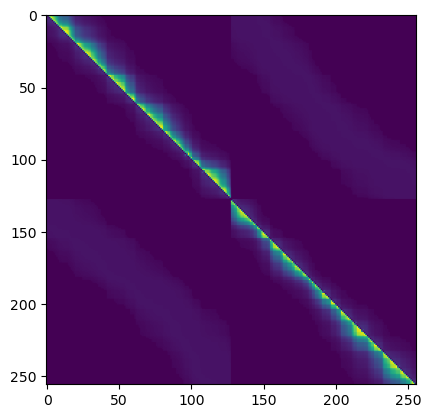

In [6]:
plt.imshow(A)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/adjourner/miniforge3/envs/FEARFRED/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


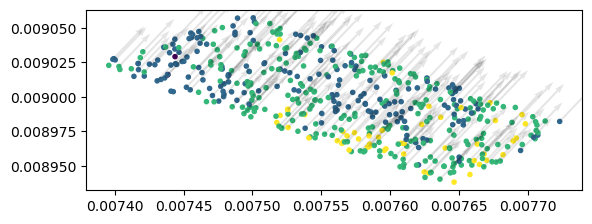

 10%|▉         | 48/500 [05:27<50:59,  6.77s/it]

In [7]:
from FEARFRED.plotting import plot_flow_field_2d
for e in trange(n_epochs):
    i = 0
    for A, features in dataloader:
        i += 1
        # shape wrangling: presently each batch has but a single matrix and list of features
        A = A[0].float().to(device)
        features = features[0][:,None] # reshape to n_nodes x n_features
        features = features.float().to(device)

        opt_discrim.zero_grad()
        loss = fred.train_critic(A, features)
        if loss.item() != loss.item():
            print("A nan has been found in d! investigate please")
            raise NotImplementedError
        loss.backward()
        opt_discrim.step()
        # print('discrim loss',loss)

        for p in fred.discriminator.parameters():
            p.data.clamp_(-weight_clipping_value, weight_clipping_value)

        if i % n_critic == 0:
            # Train generator
            opt_gen.zero_grad()
            loss = fred.train_generator(A, features)
            # print('gen loss',loss)
            if loss.item() != loss.item():
                print("A nan has been found in g! investigate please")
                raise NotImplementedError
            loss.backward()
            opt_gen.step()
    if e % 50==0:
        plot_flow_field_2d(fred.generator)

In [ ]:
fred.generate_fake()

In [ ]:
A.device

In [ ]:
fred.device

In [ ]:
fred.generator.flow_artist(torch.ones(2))

In [ ]:
from FEARFRED.datasets.manifolds import SwissRoll
from torch.utils.data import DataLoader
from FEARFRED.plotting import visualize_graph
d = SwissRoll(n_nodes=128)
dataloader = DataLoader(d, batch_size=1)
for data in dataloader:
    A, features = data
    A = A[0]
    print(A.shape)
    visualize_graph(A.numpy())
    break